# Test data augmentation

In [68]:
import pickle, os, sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")
from utils import perform_calculation, plot_mat_comp
from scf_guess_tools import  Backend, load

In [69]:

with open('models/test_data.pkl', 'rb') as f:
    test = pickle.load(f)
with open('models/train_data.pkl', 'rb') as f:
    train = pickle.load(f)
train_X = np.array([overlap for _, overlap, _, _ in train])
train_y = np.array([fock for fock, _, _, _ in train])
test_X = np.array([overlap for _, overlap, _, _ in test])
test_y = np.array([fock for fock, _, _, _ in test])
train_files = np.array([file for _, _, file, _ in train])
test_files = np.array([file for _, _, file, _ in test])
train_densities = np.array([density for _, _, _, density in train])
test_densities = np.array([density for _, _, _, density in test])
mat_dim = train_X[0].shape[0]
mat_dim

49

In [ ]:
import numpy as np
import re

def permute_xyz_file(filename, perm_index=None,  tmp_file = "/tmp/perm.xyz"): 
    """Permute the coordinates of a XYZ file."""
    with open(filename, 'r') as f:
        lines = f.readlines()
    num_atoms = int(lines[0])
    atom_lines = lines[2:2 + num_atoms]
    perm_index = np.random.permutation(num_atoms) if perm_index is None else perm_index

    permuted_lines = [atom_lines[i] for i in perm_index]
    lines = lines[:2] + list(permuted_lines)  
    with open(tmp_file, 'w') as f:
        f.writelines(lines)
    return tmp_file, np.argsort(perm_index) # inverse permutation

def reverse_mat_permutation(M, atom_labels, inv_perm_index):
    """Reverse the permutation of a matrix.
    atom_labels: ao_labels() return for mol"""
    atom_ids = []
    pattern = re.compile(r'(\d+)')
    for lbl in atom_labels:
        match = pattern.search(lbl)
        if match:
            atom_ids.append(int(match.group(1)))
        else:
            raise ValueError(f"Keine Atom-ID in Label: {lbl}")
    unique_ids = sorted(set(atom_ids))
    start = 0
    atom_ranges = []
    for uid in unique_ids:
        count_id = atom_ids.count(uid)
        atom_ranges.append((start, start + count_id))
        start += count_id
    reordered_ranges = [atom_ranges[i] for i in inv_perm_index]
    reordered_indices = []
    for (s, e) in reordered_ranges:
        reordered_indices.extend(range(s, e))
    return M[np.ix_(reordered_indices, reordered_indices)]

In [ ]:
rand_ind = np.random.randint(0, len(train_X))
orig_overlap = train_X[rand_ind]
orig_fock = train_y[rand_ind]
orig_file = train_files[rand_ind]
perm_file, inv_perm_index = permute_xyz_file(orig_file)

mol_orig = load(orig_file, Backend.PY).native
mol_perm = load(perm_file, Backend.PY).native
print(inv_perm_index)
print(", ".join(mol_orig.ao_labels()))
print   (", ".join(mol_perm.ao_labels()))

In [72]:
perm_recalc = perform_calculation(perm_file, 
                                    None,
                                    "sto-3g",
                                    "dft",
                                    "b3lypg")
orig_recalc = perform_calculation(orig_file, 
                                    None,
                                    "sto-3g",
                                    "dft",
                                    "b3lypg")
mol_orig = orig_recalc["mol"]
mol_perm = perm_recalc["mol"]
F_perm_recalc = perm_recalc["wf"].get_fock()
ovlp_perm_recalc = perm_recalc["wf"].make_rdm1()
ovlp_orig = orig_recalc["wf"].make_rdm1()
F_orig_recalc = orig_recalc["wf"].get_fock()

converged SCF energy = -446.870329717584
converged SCF energy = -446.870329717586


So jetzt unterscheiden sich die Matrizen

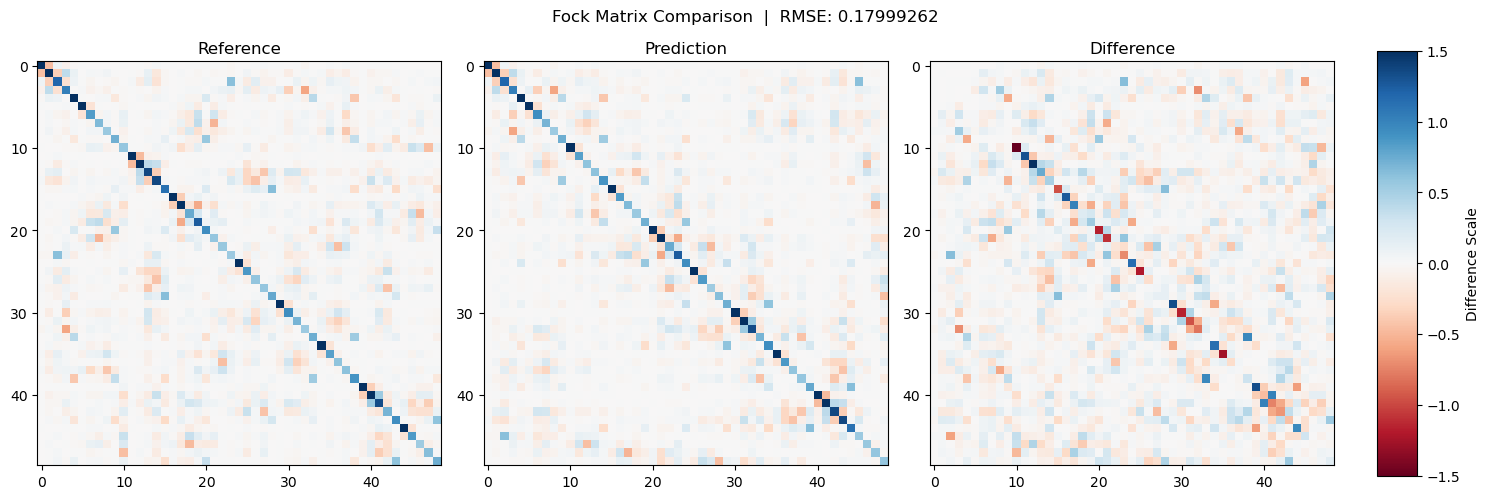

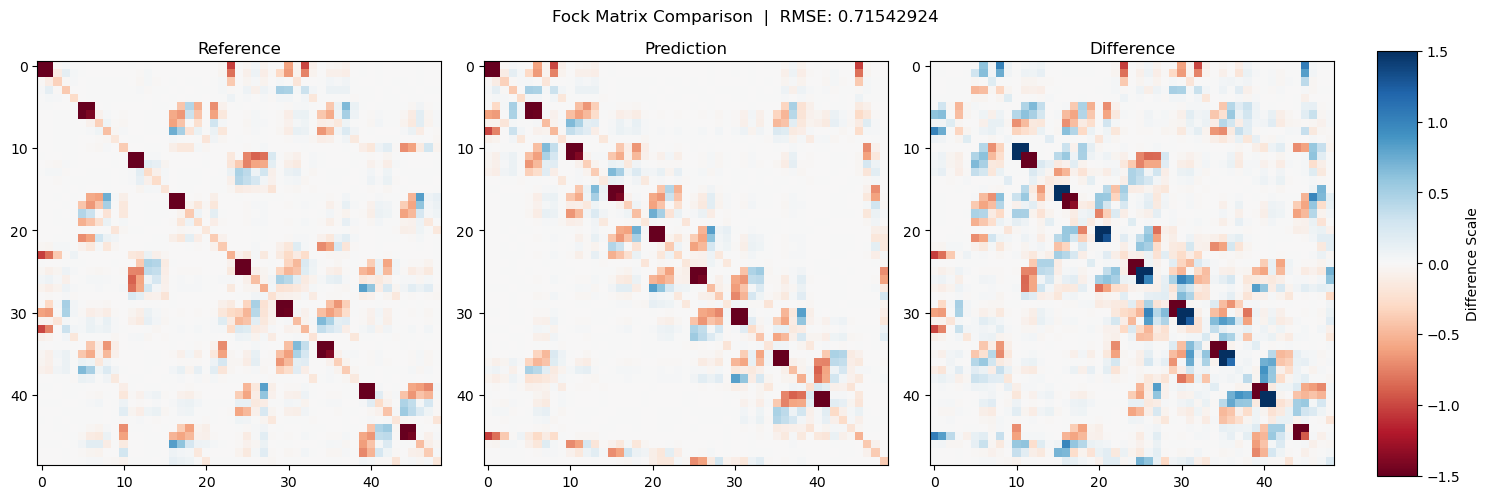

In [73]:
plot_mat_comp(ovlp_perm_recalc, ovlp_orig)
plot_mat_comp(F_perm_recalc, F_orig_recalc)

ok Inverse Transform works :)

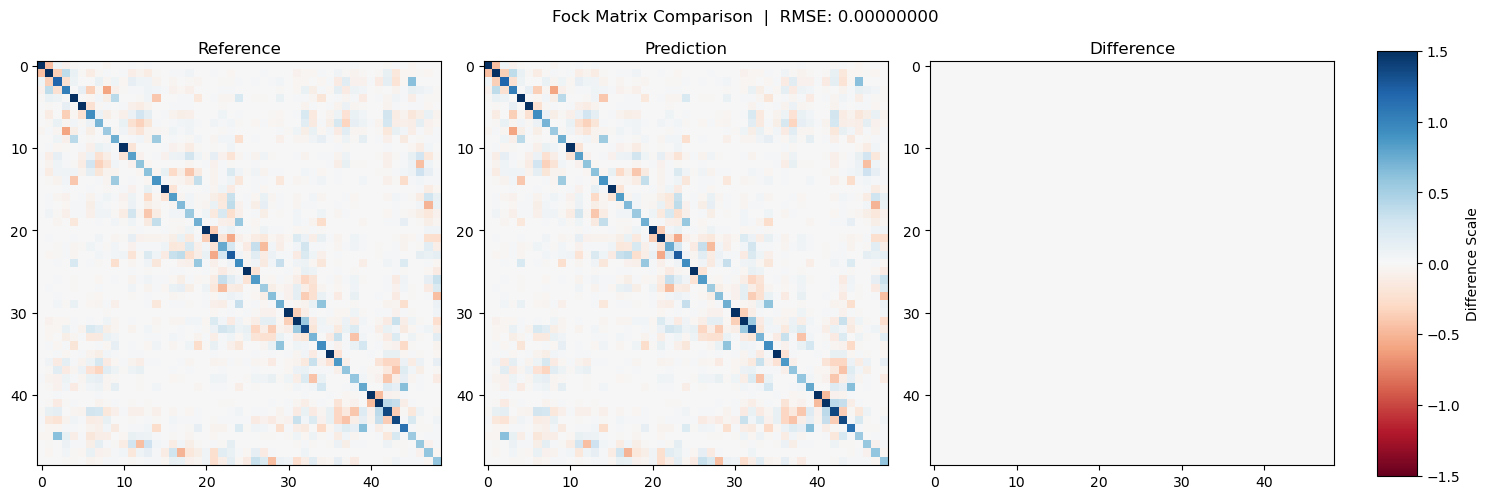

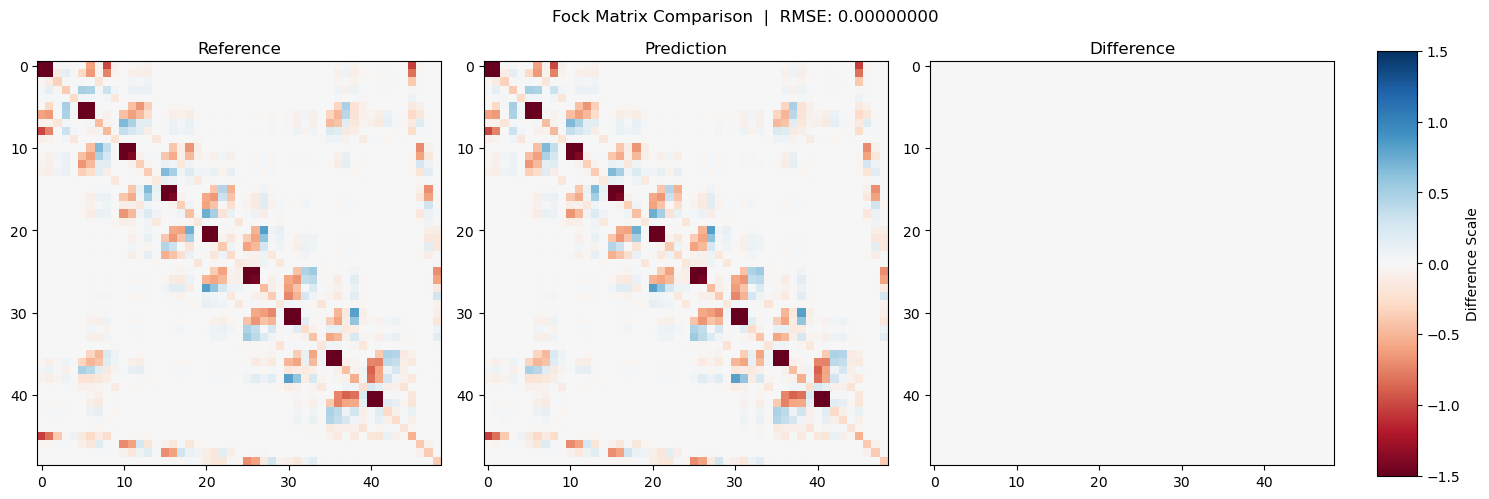

In [82]:
inv_ovlp_perm_recalc = reverse_mat_permutation(ovlp_perm_recalc, mol_perm.ao_labels(), inv_perm_index)
inv_F_perm_recalc = reverse_mat_permutation(F_perm_recalc, mol_perm.ao_labels(), inv_perm_index)
plot_mat_comp(ovlp_orig, inv_ovlp_perm_recalc)
plot_mat_comp(F_orig_recalc, inv_F_perm_recalc)

Ok testen wir wie man das verwendet! 


In [ ]:
# 1 - make aug overlap inputs from orig_overlap
orig_overlap = train_X[rand_ind]
orig_fock = train_y[rand_ind]
orig_file = train_files[rand_ind]

# generate permuted mat and use it to train!
perm_index = np.random.permutation(13)
inv_perm_index = np.argsort(perm_index)
perm_overlap = reverse_mat_permutation(orig_overlap, mol_orig.ao_labels(), perm_index)
perm_fock = reverse_mat_permutation(orig_fock, mol_orig.ao_labels(), perm_index)




In [107]:
# benchmark if perm_fock is correct
perm_file, inv_perm_index = permute_xyz_file(orig_file, perm_index)
perm_recalc = perform_calculation(perm_file, 
                                    None,
                                    "sto-3g",
                                    "dft",
                                    "b3lypg")
mol_perm = perm_recalc["mol"]
F_perm_recalc = perm_recalc["wf"].get_fock()


converged SCF energy = -446.870329717585


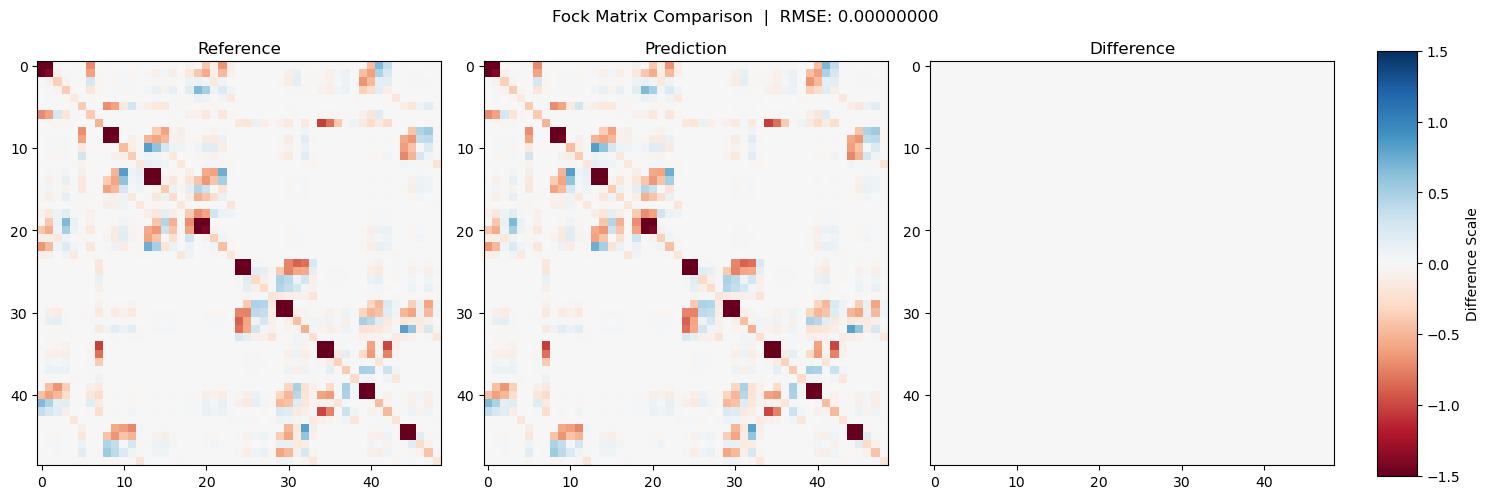

In [108]:
plot_mat_comp(perm_fock, F_perm_recalc)

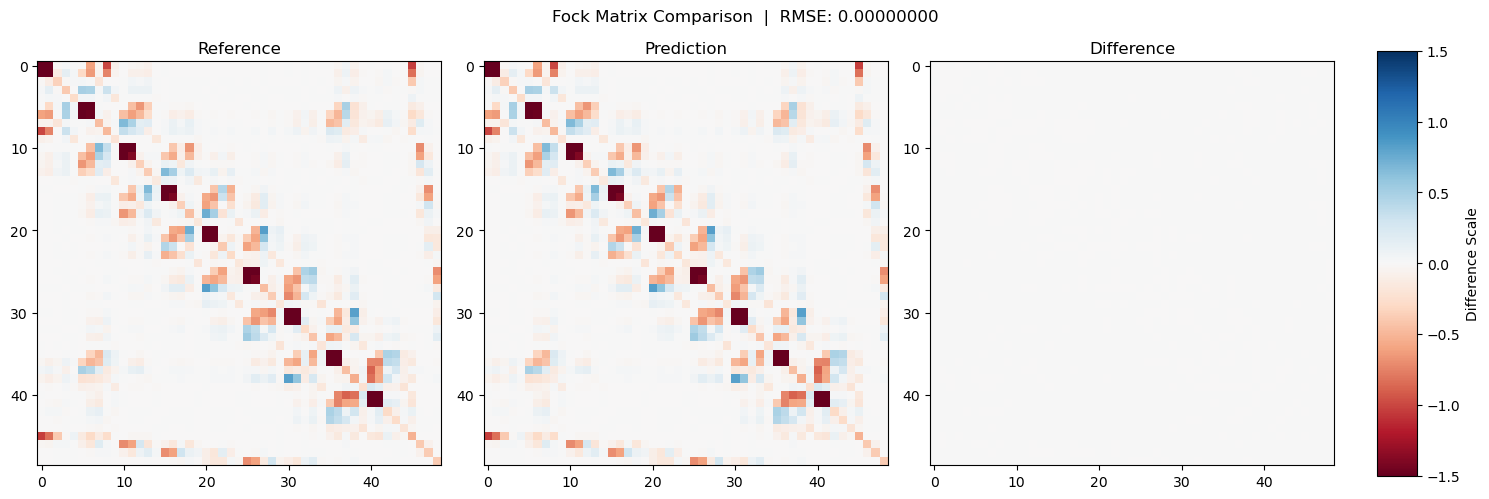

In [109]:
# check reverse transform
fock_inv = reverse_mat_permutation(F_perm_recalc, mol_perm.ao_labels(), inv_perm_index)
plot_mat_comp(orig_fock, fock_inv)